<a href="https://colab.research.google.com/github/gut-puncture/Compound_Embedding_Reasoning/blob/main/Compound_Embedding_Reasoning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # connecting google drive to this notebook

!pip -q install --upgrade "transformers==4.41.2" "accelerate>=0.29.0" \
                "sentencepiece" "datasets>=2.19.0" "pandas" "matplotlib" "huggingface_hub>=0.23.0" "fsspec>=2024.3.0"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Inference

In [ ]:
import torch, re, math, pandas as pd, matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
import random, textwrap

# ---------- paths ---------------------------------------------------------
MODEL_DIR           = "/content/drive/MyDrive/phi3_3.8B"   # NEED THIS MODEL TO BE PRESENT IN GOOGLE DRIVE
BASELINE_HF_MODEL   = "microsoft/phi-3-mini-4k-instruct"   # reference

# ---------- thinking parameters ------------------------------------------
ALPHA               = 0.25
COMPOUND_P          = 0.8
SAMPLE_P            = 0.80
STOP_ENTROPY        = 0.1   # entropy threshold (nats) below which we count steps
LENGTH_THRESHOLD    = 8      # consecutive low-entropy steps for Cold-Stop
MAX_THINK_STEPS     = 200

# ---------- token markers -------------------------------------------------
REASON_START = "### Reasoning:\n"
REASON_END   = "###"
ANS_START    = "### Answer:\n"

DEVICE  = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE   = torch.float16 if DEVICE == "cuda" else torch.float32

# Note: tokenizer will be loaded later in cell 9
# We'll add the END_SEQ_CANDIDATES after tokenizer is available

#Helper Functions - Phase 1

In [ ]:
from collections import deque

def create_compound_vector(model_outputs, embeddings, dtype, p=COMPOUND_P):
    logits = model_outputs.logits[:, -1, :]
    probs  = torch.softmax(logits, dim=-1)
    sorted_probs, sorted_idx = torch.sort(probs, descending=True)
    cum    = torch.cumsum(sorted_probs, dim=-1)
    mask   = cum <= p #all elements with cumulative prob less than p are True and all others False in mask
    mask[..., 0] = True #first element is hard coded to True so we ALWAYS choose at least one element
    sel_idx, sel_prob = sorted_idx[mask], sorted_probs[mask] #selecting all the token ids and their probs for which cumulative prob is less than p

    # FIXED: Normalize the probabilities so they sum to 1
    weights = sel_prob / sel_prob.sum()
    vec = (embeddings(sel_idx) * weights.unsqueeze(-1)).sum(0, keepdim=True)
    return vec.to(dtype).unsqueeze(0)

def sample_token_normally(model_outputs, p=SAMPLE_P): #essentially the same function as above but gives just the sampled token id
    logits = model_outputs.logits[:, -1, :]
    probs  = torch.softmax(logits, dim=-1)
    sorted_probs, sorted_idx = torch.sort(probs, descending=True)
    mask   = torch.cumsum(sorted_probs, dim=-1) <= p
    mask[..., 0] = True

    # FIXED: Normalize probabilities before sampling
    selected_probs = sorted_probs[mask]
    normalized_probs = selected_probs / selected_probs.sum()
    choice = torch.multinomial(normalized_probs, 1)
    return sorted_idx[mask][choice]

def create_thinking_vector(comp_vec, samp_tok, embeddings, dtype, alpha=ALPHA):
    samp_emb = embeddings(samp_tok).unsqueeze(0).to(dtype)
    return (1-alpha)*samp_emb + alpha*comp_vec.to(dtype) #creating a weigthed sum of the sampled token vector and the compound vector

class ThinkGenerator: #Completely AI written
    """
    Callable: prompt -> (answer_text, steps, entropy_list, stopping_reason)
    """
    def __init__(self, model_path):
        self.tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
        self.model     = AutoModelForCausalLM.from_pretrained(
                            model_path, torch_dtype=DTYPE, device_map="auto")
        self.embed     = self.model.model.embed_tokens
        self.dtype     = next(self.model.parameters()).dtype
        self.device    = next(self.model.parameters()).device

    @torch.inference_mode()
    def __call__(self, full_prompt:str):
        ids   = self.tokenizer(full_prompt, return_tensors="pt").input_ids.to(self.device) #converts string to tokens
        embeds = self.embed(ids).to(self.dtype) #embeddings of the token ids
        ent_hist = []
        # low_entropy_steps = 0  # Counter for consecutive low-entropy steps   # ← DISABLED

        # Initialize rolling buffer for end token detection
        end_buf = deque(maxlen=MAX_END_SEQ_LEN)
        reason_end_already_added = False  # FIXED: Track if we already added the end token
        stopping_reason = "max_steps"  # Default stopping reason

        # Reasoning loop for model
        # STOPPING CONDITIONS:
        # 1. Reasoning end token "###" is sampled
        # 2. Maximum reasoning steps (MAX_THINK_STEPS) reached
        for step in range(MAX_THINK_STEPS):
            # FIXED: Add proper attention mask for inputs_embeds
            attention_mask = torch.ones(embeds.size()[:2], device=embeds.device)
            outs   = self.model(inputs_embeds=embeds, attention_mask=attention_mask) #vector embeddings injected in model rather than token ids
            logits = outs.logits[:, -1, :]
            p      = torch.softmax(logits, dim=-1)

            # Calculate entropy (still logged for analysis)
            ent_value = -(p * p.log()).sum().item()
            ent_hist.append(ent_value)

            # --- Cold-Stop disabled -------------------------------------------------
            # if ent_value < STOP_ENTROPY:
            #     low_entropy_steps += 1
            # else:
            #     low_entropy_steps = 0
            #
            # if low_entropy_steps >= LENGTH_THRESHOLD:
            #     # Force end-token when Cold-Stop triggers
            #     reason_end_tok = torch.tensor([[reason_end_token_id]], device=self.device)
            #     plain_emb = self.embed(reason_end_tok).to(self.dtype)
            #     embeds = torch.cat([embeds, plain_emb], 1)
            #     ids = torch.cat([ids, reason_end_tok], 1)
            #     reason_end_already_added = True
            #     stopping_reason = "cold_stop"
            #     break
            # -----------------------------------------------------------------------

            comp = create_compound_vector(outs, self.embed, self.dtype)
            tok  = sample_token_normally(outs)

            # Add token to buffer for end sequence detection
            end_buf.append(tok.item())

            # Check if we've matched any end sequence
            break_outer = False
            for seq in END_SEQ_CANDIDATES:
                if len(end_buf) >= len(seq) and list(end_buf)[-len(seq):] == seq:
                    stopping_reason = "sampled_end_token"
                    reason_end_already_added = True
                    break_outer = True
                    break

            vec  = create_thinking_vector(comp, tok, self.embed, self.dtype)
            embeds = torch.cat([embeds, vec], 1) #adding the compound vector to the previous token vectors
            ids    = torch.cat([ids, tok.unsqueeze(0)], 1)

            if break_outer:
                break

        # Ensure reasoning end token is always added if we exit due to max steps
        if not reason_end_already_added:
            # Use the first candidate sequence (should be the simplest "###")
            reason_end_tokens = torch.tensor([END_SEQ_CANDIDATES[0]], device=self.device)
            reason_end_embeds = self.embed(reason_end_tokens).to(self.dtype)
            embeds = torch.cat([embeds, reason_end_embeds], 1)
            ids = torch.cat([ids, reason_end_tokens], 1)
            reason_end_already_added = True
            stopping_reason = "max_steps"

        # Conditional delimiter to avoid duplicate "###"
        if reason_end_already_added:
            # Only add the answer start part since "###" is already there
            delim_text = f"\n{ANS_START}"
        else:
            # Add both end and answer start
            delim_text = f"{REASON_END}\n{ANS_START}"

        delim = self.tokenizer(delim_text, add_special_tokens=False, return_tensors="pt").input_ids.to(self.device)
        delim_embeds = self.embed(delim).to(self.dtype)

        # Concatenate delimiter embeddings and IDs to maintain compound context
        embeds = torch.cat([embeds, delim_embeds], 1)
        ids = torch.cat([ids, delim], 1)

        # Use both input_ids and inputs_embeds to preserve full context while using compound embeddings
        attention_mask = torch.ones_like(ids)
        gen = self.model.generate(
            input_ids=ids,
            inputs_embeds=embeds,
            attention_mask=attention_mask,
            max_new_tokens=50,
            do_sample=False,
            pad_token_id=self.tokenizer.eos_token_id
        )
        text = self.tokenizer.decode(gen[0])
        return text, len(ent_hist), ent_hist, stopping_reason


#Main Loop

In [ ]:
# Add 8 few-shot examples so we can compare performace with 8 shot eval
FEW_SHOT_BLOCK = """
Example Questions and Answers:
Question: If you roll 2 standard six-sided dice, what is the probability that the sum is 5?
### Reasoning:
The pairs that sum to 5 are (1,4), (2,3), (3,2), (4,1).\
There are 4 favourable outcomes out of 36 total. Probability = 4/36 = 1/9.
###
### Answer:
1/9

Question: A rectangle has length 8 cm and width 5 cm. What is its area in square centimetres?
### Reasoning:
Area = length × width = 8 × 5 = 40 cm².
###
### Answer:
40

Question: Sarah has 3 red, 4 blue, and 5 green marbles. If she randomly chooses one, what is the probability it is blue?
### Reasoning:
Total marbles = 3+4+5 = 12. Blue count = 4. Probability = 4/12 = 1/3.
###
### Answer:
1/3

Question: What is 15 % of 80?
### Reasoning:
0.15 × 80 = 12.
###
### Answer:
12

Question: A train travels 180 km in 3 hours. What is its average speed in km per hour?
### Reasoning:
Speed = distance / time = 180 / 3 = 60 km/h.
###
### Answer:
60

Question: The number x satisfies 3x + 7 = 22. What is x?
### Reasoning:
3x = 22 − 7 = 15 ⇒ x = 15/3 = 5.
###
### Answer:
5

Question: A square has perimeter 24 cm. What is the length of one side in centimetres?
### Reasoning:
Perimeter = 4s ⇒ s = 24/4 = 6 cm.
###
### Answer:
6

Question: Mike scores 70, 80, 90 on three tests. What average must he score on a 4th test to have a mean of 85?
### Reasoning:
Desired total = 85×4 = 340. Current total = 70+80+90 = 240. Needed = 340−240 = 100.
###
### Answer:
100
""".strip()

SYSTEM_PROMPT = """You are an AI model which is being evaluated to see how well you're able to solve few reasoning questions which all have integer answers.
From the next line, I have given you a few examples of the kind of questions you can expect, how you must reason to solve them and how to answer.
Then you will see the words "Test Question" which will be the question you need to answer in the test.
Think between the reasoning tokens and then write the answer. You must always end the reasoning with the token "###" but only and only when you're ready to provide the answer.
Once you're done with reasoning, you can provide the answer.
The first integer after "### Answer:\n" in your generation will be what I will take as your answer and if it doesn't match with the answer given, I will give you 0 reward.
Even more important is to simply answer just the test question and stop generating tokens after the integer answer. """


In [ ]:
import random, textwrap

gsm_test  = load_dataset("gsm8k", "main", split="test").shuffle(seed=21).select(range(25))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
tok_base  = AutoTokenizer.from_pretrained(BASELINE_HF_MODEL, trust_remote_code=True)
mod_base  = AutoModelForCausalLM.from_pretrained(BASELINE_HF_MODEL,
                                                 torch_dtype=DTYPE, device_map="auto")

# --- reasoning-end detection ------------------------------------------
REASON_END_RAW = "###"
END_SEQ_CANDIDATES = [
    tok_base.encode("###", add_special_tokens=False),
    tok_base.encode(" ###", add_special_tokens=False),
    tok_base.encode("\n###", add_special_tokens=False),
    tok_base.encode("\n ###", add_special_tokens=False),
]
MAX_END_SEQ_LEN = max(len(seq) for seq in END_SEQ_CANDIDATES)

think_gen = ThinkGenerator(MODEL_DIR)

def build_prompt(question: str) -> str:
    return f"{SYSTEM_PROMPT}\n{FEW_SHOT_BLOCK}\n\n Test Question: {question}\n{REASON_START}"

def gold_int(ans: str) -> str:
    ints = re.findall(r"-?\d+", ans)
    return ints[-1] if ints else "" #results in the final integer in the model's generation

@torch.inference_mode()
def baseline_answer(question: str) -> str:
    prompt = build_prompt(question)
    ids    = tok_base(prompt, return_tensors="pt").input_ids.to(DEVICE)
    gen    = mod_base.generate( #answer generate by vanilla model for comparison. we defined the vanilla model's name and simply use that.
                ids,
                max_new_tokens=256,
                do_sample=False,
                attention_mask=torch.ones_like(ids),
                pad_token_id=tok_base.eos_token_id
            )
    text = tok_base.decode(gen[0])
    return text


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# Eval

In [ ]:
# Full evaluation on 500 questions - Phase 1: Generate raw outputs only
print("Running full evaluation on 500 questions (Phase 1: Raw outputs only)...\n")

rows = []
for i, ex in enumerate(gsm_test):
    if i % 50 == 0:
        print(f"Processing question {i}/500...")

    q_raw, gold_raw = ex["question"], ex["answer"]
    gold_num = gold_int(gold_raw)

    # Get baseline answer (raw text only)
    base_text = baseline_answer(q_raw)

    # Get thinking model answer (raw text only)
    think_text, steps, ent, stop_reason = think_gen(build_prompt(q_raw))

    rows.append({
        "id": i,
        "question": q_raw,
        "gold": gold_num,
        "steps": steps,
        "entropy_avg": sum(ent)/len(ent) if ent else 0,
        "stopping_reason": stop_reason,
        "baseline_raw": base_text.split("Test Question:", 1)[-1].replace("\n", " \\n "),
        "think_raw": think_text.split("Test Question:", 1)[-1].replace("\n", " \\n ")
    })

df = pd.DataFrame(rows)
df.to_csv("/content/drive/MyDrive/gsm8k_think_metrics_phase1.csv", index=False)
print("\nPhase 1 evaluation complete! Raw outputs saved.")
print("Next: Switch to CPU runtime and run Phase 2 for DeepSeek adjudication.")

Running full evaluation on 500 questions (Phase 1: Raw outputs only)...

Processing question 0/500...

Phase 1 evaluation complete! Raw outputs saved.
Next: Switch to CPU runtime and run Phase 2 for DeepSeek adjudication.



Phase 1 Complete: Generated raw outputs for 500 GSM-8K questions
Raw outputs saved to: /content/drive/MyDrive/gsm8k_think_metrics_phase1.csv



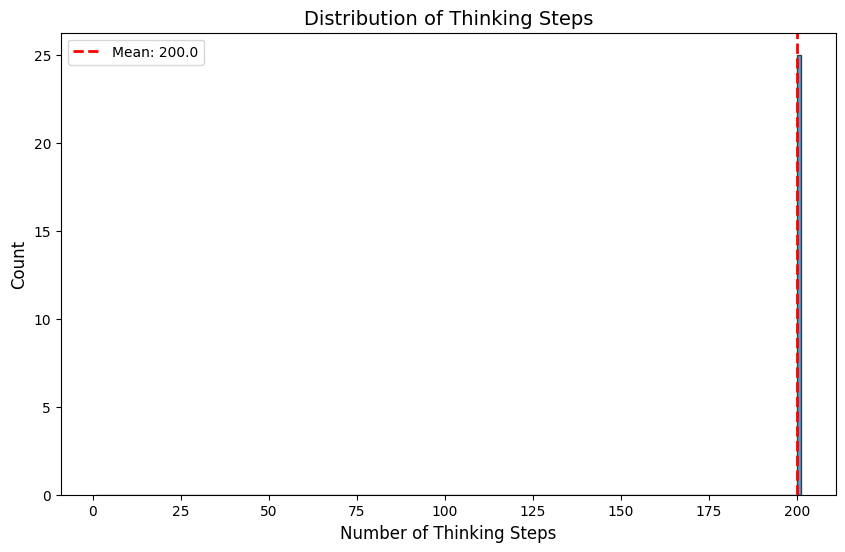

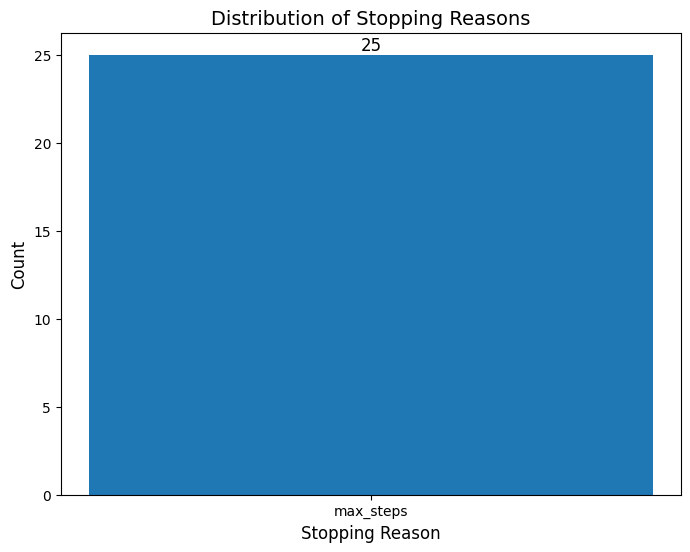


Next step: Switch runtime to CPU and run Phase 2 for DeepSeek adjudication.


In [ ]:
# Basic Phase 1 Statistics (no accuracy analysis yet)
print(f"\n" + "="*50)
print(f"Phase 1 Complete: Generated raw outputs for 500 GSM-8K questions")
print(f"Raw outputs saved to: /content/drive/MyDrive/gsm8k_think_metrics_phase1.csv")
print("="*50 + "\n")

# Thinking steps distribution
plt.figure(figsize=(10, 6))
plt.hist(df["steps"], bins=range(1, MAX_THINK_STEPS+2), alpha=0.7, edgecolor='black')
plt.title("Distribution of Thinking Steps", fontsize=14)
plt.xlabel("Number of Thinking Steps", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.axvline(df["steps"].mean(), color='red', linestyle='dashed', linewidth=2,
            label=f'Mean: {df["steps"].mean():.1f}')
plt.legend()
plt.show()

# Stopping reasons distribution
stop_counts = df["stopping_reason"].value_counts()
plt.figure(figsize=(8, 6))
bars = plt.bar(stop_counts.index, stop_counts.values,
               color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title("Distribution of Stopping Reasons", fontsize=14)
plt.ylabel("Count", fontsize=12)
plt.xlabel("Stopping Reason", fontsize=12)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontsize=12)
plt.show()

print("\nNext step: Switch runtime to CPU and run Phase 2 for DeepSeek adjudication.")

In [ ]:
# Phase 1 data already saved above - this cell can be deleted or used for verification
print(f"Phase 1 data contains {len(df)} rows with columns: {list(df.columns)}")
print(f"File saved to: /content/drive/MyDrive/gsm8k_think_metrics_phase1.csv")

Phase 1 data contains 75 rows with columns: ['id', 'question', 'gold', 'steps', 'entropy_avg', 'stopping_reason', 'baseline_raw', 'think_raw']
File saved to: /content/drive/MyDrive/gsm8k_think_metrics_phase1.csv


# Phase 2: DeepSeek Adjudication

In [ ]:
#**Instructions:**
#1. Switch runtime to CPU
#2. Run the cells below to send raw outputs to DeepSeek-Reasoner for answer extraction
#3. This will take approximately 35 minutes (1000 API calls at 30 req/min)


In [ ]:
# Install required packages and check environment
!pip -q install --upgrade openai backoff

import os
import json
import time
import re
import pandas as pd
import matplotlib.pyplot as plt
from openai import OpenAI
import backoff
from google.colab import userdata # Import userdata

# Verify API key is set
api_key = userdata.get('DEEPSEEK_API_KEY')
os.environ["DEEPSEEK_API_KEY"] = api_key
assert "DEEPSEEK_API_KEY" in os.environ, "Please set DEEPSEEK_API_KEY environment variable"
print("✓ DeepSeek API key found")

✓ DeepSeek API key found


In [ ]:
from google.colab import drive
drive.mount('/content/drive') # connecting google drive to this notebook

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# DeepSeek configuration and helper functions
DEEPSEEK_BASE_URL = "https://api.deepseek.com/v1"
DEEPSEEK_MODEL = "deepseek-reasoner"
DEEPSEEK_SYSTEM_PROMPT = """
You are DeepSeek-Reasoner and you're helping me check answers from a different AI model. The other model was given a math word-problem QUESTION and
it generate it's answer as MODEL_OUTPUT. Read the reasoning of the model and it's entire output.
Sometimes you may find that the model gives an answer and then makes up another question and it's reasoning and answer and so on.
Sometimes the model's reasoning ends abruptly and then it outputs the answer.
You must be smart and identify the integer answer that the model asserted ONLY for the question we provide to you.
Ignore all of the text the model may generate which is unrelated to the question.

Respond STRICTLY in valid JSON:
{ "answer": <integer> }

Do not wrap the JSON in markdown, do not add keys, and do not explain.
"""
RESPONSE_FORMAT = {"type": "json_object"}
REQUEST_INTERVAL_SEC = 2.1  # ~30 requests per minute
MAX_RETRY_DELAY_SEC = 60

# Initialize OpenAI client for DeepSeek
client = OpenAI(
    api_key=os.environ["DEEPSEEK_API_KEY"],
    base_url=DEEPSEEK_BASE_URL
)

@backoff.on_exception(
    backoff.expo,
    (Exception,),  # Catch all exceptions for robustness
    max_time=None,  # keep trying indefinitely
    factor=2,
    max_value=MAX_RETRY_DELAY_SEC
)
def deepseek_extract_answer(question: str, model_output: str) -> tuple[str, str]:
    """
    Extract integer answer from model output using DeepSeek-Reasoner.
    Returns: (answer_integer, full_deepseek_response)
    """
    user_msg = f"QUESTION:\n{question}\n\nMODEL_OUTPUT:\n{model_output}"

    try:
        resp = client.chat.completions.create(
            model=DEEPSEEK_MODEL,
            messages=[
                {"role": "system", "content": DEEPSEEK_SYSTEM_PROMPT},
                {"role": "user", "content": user_msg}
            ],
            response_format=RESPONSE_FORMAT,
            max_tokens=2000
        )

        full_text = resp.choices[0].message.content

        # Best-effort JSON parse (in case CoT leaks); keep whole text
        try:
            # Find JSON in response
            first_brace = full_text.find('{')
            last_brace = full_text.rfind('}')
            if first_brace != -1 and last_brace != -1:
                json_str = full_text[first_brace:last_brace+1]
                js = json.loads(json_str)
                ans = str(js["answer"])
            else:
                raise ValueError("No JSON found")
        except Exception as e:
            print(f"JSON parsing failed: {e}")
            # Fall back to last integer in text
            ints = re.findall(r"-?\d+", full_text)
            ans = ints[-1] if ints else ""

        return ans, full_text

    except Exception as e:
        print(f"API call failed: {e}")
        raise  # Let backoff handle retry

print("✓ DeepSeek helper functions defined")


✓ DeepSeek helper functions defined


In [ ]:
# Test DeepSeek API with one sample
print("Testing DeepSeek API with a sample question...")

# Load the Phase 1 data
df_phase1 = pd.read_csv("/content/drive/MyDrive/gsm8k_think_metrics_phase1.csv")
print(f"Loaded {len(df_phase1)} questions from Phase 1")

# Test with first question
test_question = df_phase1.iloc[0]["question"]
test_baseline_raw = df_phase1.iloc[0]["baseline_raw"].replace(" \\n ", "\n")
test_gold = df_phase1.iloc[0]["gold"]

print(f"\nTest Question: {test_question[:100]}...")
print(f"Gold Answer: {test_gold}")

try:
    # Test baseline
    ans_baseline, raw_baseline = deepseek_extract_answer(test_question, test_baseline_raw)
    print(f"✓ DeepSeek baseline extraction: {ans_baseline}")
    print(f"  Full response: {raw_baseline[:200]}...")

    print("\nDeepSeek API test successful! Ready for full processing.")

except Exception as e:
    print(f"❌ DeepSeek API test failed: {e}")
    print("Please check your API key and try again.")


Testing DeepSeek API with a sample question...
Loaded 75 questions from Phase 1

Test Question: A factory used to make tractors, but now makes silos. When they made tractors, they sold 10 tractors...
Gold Answer: 10
✓ DeepSeek baseline extraction: 10
  Full response: {"answer": 10}...

DeepSeek API test successful! Ready for full processing.


In [ ]:
# Phase 2: DeepSeek adjudication for all 500 questions
print("Starting Phase 2: DeepSeek adjudication for all 500 questions...")
print(f"This will take approximately {(len(df_phase1) * 2 * REQUEST_INTERVAL_SEC) / 60:.1f} minutes")
print("Processing with 30 requests per minute to avoid rate limits.\n")

# Initialize new columns in the dataframe
df_phase1["baseline_int_ds"] = ""
df_phase1["baseline_ds_raw"] = ""
df_phase1["think_int_ds"] = ""
df_phase1["think_ds_raw"] = ""

start_time = time.time()

for idx, row in df_phase1.iterrows():
    if idx % 50 == 0:
        elapsed = (time.time() - start_time) / 60
        remaining = (len(df_phase1) - idx) * 2 * REQUEST_INTERVAL_SEC / 60
        print(f"Processing question {idx}/500... (elapsed: {elapsed:.1f}min, remaining: {remaining:.1f}min)")

    question = row["question"]

    # Process baseline output
    baseline_raw = row["baseline_raw"].replace(" \\n ", "\n")  # Convert back from CSV format
    try:
        ans_b, raw_b = deepseek_extract_answer(question, baseline_raw)
        df_phase1.at[idx, "baseline_int_ds"] = ans_b
        df_phase1.at[idx, "baseline_ds_raw"] = raw_b
    except Exception as e:
        print(f"Failed to process baseline for question {idx}: {e}")
        df_phase1.at[idx, "baseline_int_ds"] = ""
        df_phase1.at[idx, "baseline_ds_raw"] = f"ERROR: {str(e)}"

    time.sleep(REQUEST_INTERVAL_SEC)

    # Process thinking output
    think_raw = row["think_raw"].replace(" \\n ", "\n")  # Convert back from CSV format
    try:
        ans_t, raw_t = deepseek_extract_answer(question, think_raw)
        df_phase1.at[idx, "think_int_ds"] = ans_t
        df_phase1.at[idx, "think_ds_raw"] = raw_t
    except Exception as e:
        print(f"Failed to process thinking for question {idx}: {e}")
        df_phase1.at[idx, "think_int_ds"] = ""
        df_phase1.at[idx, "think_ds_raw"] = f"ERROR: {str(e)}"

    time.sleep(REQUEST_INTERVAL_SEC)

# Calculate correctness based on DeepSeek extractions
df_phase1["correct_baseline_ds"] = df_phase1["baseline_int_ds"] == df_phase1["gold"]
df_phase1["correct_think_ds"] = df_phase1["think_int_ds"] == df_phase1["gold"]

# Save results
output_path = "/content/drive/MyDrive/gsm8k_think_metrics_deepseek.csv"
df_phase1.to_csv(output_path, index=False)

total_time = (time.time() - start_time) / 60
print(f"\n✓ Phase 2 complete! Total time: {total_time:.1f} minutes")
print(f"DeepSeek adjudication results saved to: {output_path}")


Starting Phase 2: DeepSeek adjudication for all 500 questions...
This will take approximately 5.2 minutes
Processing with 30 requests per minute to avoid rate limits.

Processing question 0/500... (elapsed: 0.0min, remaining: 5.2min)
JSON parsing failed: No JSON found
JSON parsing failed: No JSON found


KeyboardInterrupt: 

In [ ]:
output_path = "/content/drive/MyDrive/gsm8k_think_metrics_deepseek.csv"
df_phase1.to_csv(output_path, index=False)

In [ ]:
# Final Results Analysis with DeepSeek Adjudication
df_final = df_phase1  # Use the dataframe with DeepSeek results

# Calculate accuracies using DeepSeek-extracted answers
base_acc_ds = df_final["correct_baseline_ds"].mean()
think_acc_ds = df_final["correct_think_ds"].mean()

print(f"\n" + "="*60)
print(f"FINAL RESULTS (DeepSeek-Reasoner Adjudicated)")
print(f"="*60)
print(f"Baseline φ-3 accuracy on 500 GSM-8K questions: {base_acc_ds:.2%}")
print(f"Think-advance model accuracy: {think_acc_ds:.2%}")
print(f"Improvement: {(think_acc_ds - base_acc_ds):.2%} ({(think_acc_ds/base_acc_ds - 1)*100:.1f}% relative)")
print("="*60 + "\n")

# Accuracy comparison
plt.figure(figsize=(10, 6))
bars = plt.bar(["Baseline φ-3", "Think-Advance"], [base_acc_ds, think_acc_ds],
                color=['#1f77b4', '#ff7f0e'])
plt.title("GSM-8K Accuracy Comparison (500 questions, DeepSeek-Reasoner adjudicated)", fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0, max(base_acc_ds, think_acc_ds) * 1.2)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1%}', ha='center', va='bottom', fontsize=12)
plt.show()

# Thinking steps distribution (unchanged from Phase 1)
plt.figure(figsize=(10, 6))
plt.hist(df_final["steps"], bins=range(1, 201), alpha=0.7, edgecolor='black')
plt.title("Distribution of Thinking Steps", fontsize=14)
plt.xlabel("Number of Thinking Steps", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.axvline(df_final["steps"].mean(), color='red', linestyle='dashed', linewidth=2,
            label=f'Mean: {df_final["steps"].mean():.1f}')
plt.legend()
plt.show()

# Show some examples where thinking helped
think_better = df_final[(df_final["correct_think_ds"] == True) & (df_final["correct_baseline_ds"] == False)]
baseline_better = df_final[(df_final["correct_baseline_ds"] == True) & (df_final["correct_think_ds"] == False)]

print(f"\nDetailed Analysis:")
print(f"Cases where thinking model got it right but baseline didn't: {len(think_better)}")
print(f"Cases where baseline got it right but thinking didn't: {len(baseline_better)}")
print(f"Cases where both got it right: {((df_final['correct_baseline_ds'] == True) & (df_final['correct_think_ds'] == True)).sum()}")
print(f"Cases where both got it wrong: {((df_final['correct_baseline_ds'] == False) & (df_final['correct_think_ds'] == False)).sum()}")

if len(think_better) > 0:
    print(f"\nExample where thinking helped:")
    ex = think_better.iloc[0]
    print(f"Question: {ex['question'][:100]}...")
    print(f"Gold: {ex['gold']}")
    print(f"Baseline answer (DeepSeek): {ex['baseline_int_ds']}")
    print(f"Think answer (DeepSeek): {ex['think_int_ds']}")
    print(f"Think steps: {ex['steps']}")

print(f"\nFinal results saved to: /content/drive/MyDrive/gsm8k_think_metrics_deepseek.csv")


KeyError: 'correct_baseline_ds'